In [2645]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2646]:
#upload csv
df = pd.read_csv('loan.csv',low_memory=False)
# check meta info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.6+ MB


#### Remove all columns having all values as NULL

In [2647]:
df.dropna(axis=1, how='all',inplace=True)

### Drop columns which looks irrelevant, but how do we do that? We don't want to loose columns which could prove decisive
#### We will take a glance at data, small chunks at once

In [2648]:
df.iloc[0:5,0:15]

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified


#### id, member_id, emp_title won't help
#### loan_amnt, funded_amnt looks, funded_amnt_inv highly correlated

In [2649]:
df.loc[:,["loan_amnt","funded_amnt","funded_amnt_inv"]].corr()

,loan_amnt,funded_amnt,funded_amnt_inv
loan_amnt,1.000000,0.981578,0.940034
funded_amnt,0.981578,1.000000,0.958422
funded_amnt_inv,0.940034,0.958422,1.000000


#### Our observation seems to be true, we will keep loan_amnt and drop the other two since they won't add extra information

In [2650]:
df.iloc[0:5,15:30]

,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record
0,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0,Jan-85,1,NaN,NaN
1,Dec-11,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0,Apr-99,5,NaN,NaN
2,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,real estate business,606xx,IL,8.72,0,Nov-01,2,NaN,NaN
3,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0,Feb-96,1,35.0,NaN
4,Dec-11,Current,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,17.94,0,Jan-96,0,38.0,NaN


#### url, desc, purpose, title, zip_code, addr_state, earliest_cr_line looks irrelevant. We will drop them as well
#### mths_since_last_delinq, mths_since_last_record shows a lot of null values. Let's investigate them

In [2651]:
df["mths_since_last_delinq"].isnull().sum()

25682

In [2652]:
df["mths_since_last_record"].isnull().sum()

36931

#### Both of them have a lot of null values, let's drop them as well. Note that loan_status is the most important column, we will treat it as a target variable

In [2653]:
df.iloc[0:5,30:45]

,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee
0,3,0,13648,83.70%,9,f,0.00,0.00,5863.155187,5833.84,5000.00,863.16,0.00,0.00,0.00
1,3,0,1687,9.40%,4,f,0.00,0.00,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11
2,2,0,2956,98.50%,10,f,0.00,0.00,3005.666844,3005.67,2400.00,605.67,0.00,0.00,0.00
3,10,0,5598,21%,37,f,0.00,0.00,12231.890000,12231.89,10000.00,2214.92,16.97,0.00,0.00
4,15,0,27783,53.90%,38,f,524.06,524.06,3513.330000,3513.33,2475.94,1037.39,0.00,0.00,0.00


#### since we are going to delete funded_amnt_inv, total_pymnt_inv, out_prncp_inv won't make sense
#### We are not worried about principal, out_prncp and interest break down, we will delete that
#### Let's investigate pub_rec, initial_list_status, total_rec_late_fee, recoveries and collection_recovery_fee

In [2654]:
df["pub_rec"].value_counts()

0    37601
1     2056
2       51
3        7
4        2
Name: pub_rec, dtype: int64

In [2655]:
df["initial_list_status"].value_counts()

f    39717
Name: initial_list_status, dtype: int64

In [2656]:
df["total_rec_late_fee"].value_counts()

0.000000     37671
15.000000      255
15.000000       58
30.000000       55
15.000000       47
             ...  
35.286832        1
15.000000        1
14.777500        1
14.967774        1
19.890000        1
Name: total_rec_late_fee, Length: 1356, dtype: int64

In [2657]:
df["recoveries"].value_counts()

0.00       35499
11.29          4
10.40          4
10.66          3
44.92          3
           ...  
764.69         1
653.08         1
1080.96        1
878.19         1
21.29          1
Name: recoveries, Length: 4040, dtype: int64

In [2658]:
df["collection_recovery_fee"].value_counts()

0.0000      35935
2.0000         12
1.2000         10
3.7100          9
1.8800          8
            ...  
3.7900          1
773.4900        1
272.8250        1
1.7697          1
0.2300          1
Name: collection_recovery_fee, Length: 2616, dtype: int64

#### initial_list_status have same value -> not needed
#### Other three columns have almost all values as 0, and rest are negligible. We can delete them as well.

In [2659]:
df.iloc[0:5,45:]

,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
0,Jan-15,171.62,NaN,May-16,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0
1,Apr-13,119.66,NaN,Sep-13,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0
2,Jun-14,649.91,NaN,May-16,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0
3,Jan-15,357.48,NaN,Apr-16,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0
4,May-16,67.79,Jun-16,May-16,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0


#### Suspected irrelevant columns - next_pymnt_d, collections_12_mths_ex_med, policy_code, 
#### application_type, acc_now_delinq, chargeoff_within_12_mths, delinq_amnt, pub_rec_bankruptcies, tax_liens

In [2660]:
df["next_pymnt_d"].isnull().sum()

38577

In [2661]:
df["collections_12_mths_ex_med"].value_counts()

0.0    39661
Name: collections_12_mths_ex_med, dtype: int64

In [2662]:
df["policy_code"].value_counts()

1    39717
Name: policy_code, dtype: int64

In [2663]:
df["application_type"].value_counts()

INDIVIDUAL    39717
Name: application_type, dtype: int64

In [2664]:
df["acc_now_delinq"].value_counts()

0    39717
Name: acc_now_delinq, dtype: int64

In [2665]:
df["chargeoff_within_12_mths"].value_counts()

0.0    39661
Name: chargeoff_within_12_mths, dtype: int64

In [2666]:
df["delinq_amnt"].value_counts()

0    39717
Name: delinq_amnt, dtype: int64

In [2667]:
df["pub_rec_bankruptcies"].value_counts()

0.0    37339
1.0     1674
2.0        7
Name: pub_rec_bankruptcies, dtype: int64

In [2668]:
df["tax_liens"].value_counts()

0.0    39678
Name: tax_liens, dtype: int64

#### As suspected, all the suspected irrelevant columns either contains same value, or are mostly null, or contain very high amount of same values. For eg next_pymnt_d have very few non null values, whereas pub_rec_bankruptcies have very few non zero values. Let's delete all of them

###  Let's delete all the irrelevant columns together

In [2669]:
col_to_delete1 = ["id", "member_id", "emp_title", "funded_amnt","funded_amnt_inv"] # from first chunk
col_to_delete2 = ["url", "desc","title", "zip_code", "earliest_cr_line","mths_since_last_delinq", "mths_since_last_record"] # from 2nd chunk
col_to_delete3 = ["funded_amnt_inv", "total_pymnt_inv", "out_prncp_inv","pub_rec", "initial_list_status", "total_rec_late_fee", "recoveries", "collection_recovery_fee"]
col_to_delete4 = ["next_pymnt_d", "collections_12_mths_ex_med", "policy_code","application_type", "acc_now_delinq", "chargeoff_within_12_mths", "delinq_amnt", "pub_rec_bankruptcies", "tax_liens"]

In [2670]:
col_to_delete =  col_to_delete1 + col_to_delete2 + col_to_delete3 + col_to_delete4
col_to_delete

['id',
 'member_id',
 'emp_title',
 'funded_amnt',
 'funded_amnt_inv',
 'url',
 'desc',
 'title',
 'zip_code',
 'earliest_cr_line',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'funded_amnt_inv',
 'total_pymnt_inv',
 'out_prncp_inv',
 'pub_rec',
 'initial_list_status',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'next_pymnt_d',
 'collections_12_mths_ex_med',
 'policy_code',
 'application_type',
 'acc_now_delinq',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'pub_rec_bankruptcies',
 'tax_liens']

In [2671]:
df.drop(labels=col_to_delete, axis=1, inplace=True)

In [2672]:
df.shape

(39717, 29)

### Since now the data is clean, we can start performing univariate, segmeneted, bivariate analysis or could derive metrics
#### Since there are still 25 columns, performing analysis one by one could be very tedious
####  Let's first analyse the target variable, and then we can check if we could optimize the analysis instead of doing 1 by 1 analysis

In [2673]:
df["loan_status"].value_counts()

Fully Paid     32950
Charged Off     5627
Current         1140
Name: loan_status, dtype: int64

#### We don't need records with loan status as 'Current', it won't add any value to our analysis whatsoever

In [2674]:
df = df[df["loan_status"] != 'Current']


In [2675]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38577 entries, 0 to 39716
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   loan_amnt            38577 non-null  int64  
 1   term                 38577 non-null  object 
 2   int_rate             38577 non-null  object 
 3   installment          38577 non-null  float64
 4   grade                38577 non-null  object 
 5   sub_grade            38577 non-null  object 
 6   emp_length           37544 non-null  object 
 7   home_ownership       38577 non-null  object 
 8   annual_inc           38577 non-null  float64
 9   verification_status  38577 non-null  object 
 10  issue_d              38577 non-null  object 
 11  loan_status          38577 non-null  object 
 12  pymnt_plan           38577 non-null  object 
 13  purpose              38577 non-null  object 
 14  addr_state           38577 non-null  object 
 15  dti                  38577 non-null 

#### Let's try to study emp_length, revol_util, last_pymnt_d, last_credit_pull_d since they have some null values, we will fill the null values by most logical value present in those columns

In [2676]:
df["emp_length"].value_counts()

10+ years    8488
< 1 year     4508
2 years      4291
3 years      4012
4 years      3342
5 years      3194
1 year       3169
6 years      2168
7 years      1711
8 years      1435
9 years      1226
Name: emp_length, dtype: int64

#### We can fill the NA values in this column by '10+ years' since this is the most commonly occuring value [mode]. After that we can convert it to integers

In [2677]:
values = {"emp_length": "10+ years"}
df.fillna(values, inplace=True)

In [2678]:
def modify_emp_length(x):
    if x == '10+ years':
        return 10
    elif x == '< 1 year':
        return 0
    else:
        return int(x.split(' ')[0])

df['emp_length'] = df['emp_length'].apply(modify_emp_length)

In [2679]:
df["emp_length"].value_counts()

10    9521
0     4508
2     4291
3     4012
4     3342
5     3194
1     3169
6     2168
7     1711
8     1435
9     1226
Name: emp_length, dtype: int64

In [2680]:
values = {"revol_util": "0%"}
df.fillna(values, inplace=True)

In [2681]:
df["revol_util"] = df["revol_util"].apply(lambda x: float(x.split('%')[0]))

In [2682]:
df["revol_util"].value_counts()

0.00     1004
0.20       62
63.00      62
40.70      57
31.20      57
         ... 
77.63       1
25.74       1
0.83        1
47.36       1
7.28        1
Name: revol_util, Length: 1088, dtype: int64

In [2683]:
df["last_pymnt_d"].value_counts()

Mar-13    1026
Dec-14     945
May-13     907
Feb-13     869
Apr-13     851
          ... 
Jun-08      10
Nov-08      10
Mar-08       5
Jan-08       4
Feb-08       1
Name: last_pymnt_d, Length: 101, dtype: int64

In [2684]:
values = {"last_pymnt_d": "Mar-13"}
df.fillna(values, inplace=True)

In [2685]:
df["last_pymnt_y"] = df["last_pymnt_d"].apply(lambda x: int(x.split('-')[1]))

<AxesSubplot:>

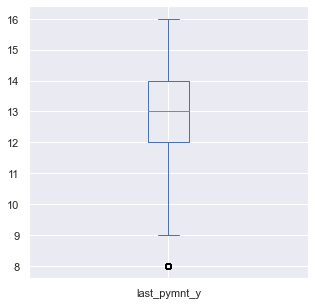

In [2686]:
sns.set(rc={'figure.figsize':(5,5)})
df["last_pymnt_y"].plot.box()

### pd.DatetimeIndex(df["last_pymnt_d"]).month is throwing error " Out of bounds nanosecond timestamp: 1-01-15 00:00:00"
### We could use pd.to_datetime(df["last_pymnt_d"], errors = 'coerce'), but it will convert some values to NAT
#### We will write a custom function to extract month from it. Year can be extracted rather easily

In [2687]:
def convertToMonth(mnth):
    x = mnth.split('-')[0]
    if x == 'Jan':
        return 1
    elif x == 'Feb':
        return 2
    elif x == 'Mar':
        return 3
    elif x== 'Apr':
        return 4
    elif x== 'May':
        return 5
    elif x=='Jun':
        return 6
    elif x == 'Jul':
        return 7
    elif x == 'Aug':
        return 8
    elif x== 'Sep':
        return 9
    elif x == 'Oct':
        return 10
    elif x == 'Nov':
        return 11
    else:
        return 12
    
df["last_pymnt_m"] = df["last_pymnt_d"].apply(convertToMonth)

#### Let's drop last_pymnt_d since we have already extracted month from it

In [2688]:
df.drop(labels=["last_pymnt_d"],axis=1,inplace=True)

In [2689]:
df["issue_m"] = df["issue_d"].apply(convertToMonth)

In [2690]:
df["issue_y"] = df["issue_d"].apply(lambda x: int(x.split('-')[1]))

<AxesSubplot:>

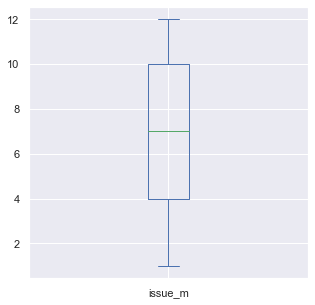

In [2691]:
df["issue_m"].plot.box()

<AxesSubplot:>

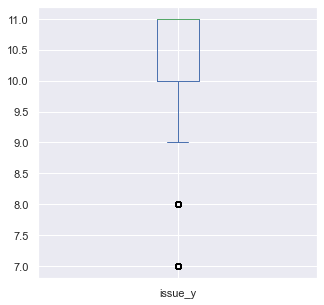

In [2692]:
df["issue_y"].plot.box()

In [2693]:
df.drop(labels=["issue_d"],axis=1,inplace=True)

#### Let's remove the outliers for loan issued date

In [2694]:
df = df[df["issue_y"] > 8]

#### Most of the loans are issued after 2009, and there are some outliers where the loans are issued in 2007 and 2008.

In [2695]:
df["last_credit_pull_d"].value_counts()

May-16    9006
Apr-16    2310
Mar-16    1095
Feb-13     834
Feb-16     718
          ... 
Apr-09       5
May-09       4
Jun-09       3
Mar-09       1
Feb-09       1
Name: last_credit_pull_d, Length: 89, dtype: int64

In [2696]:
values = {"last_credit_pull_d": "May-16"}
df.fillna(values, inplace=True)

In [2697]:
df["last_credit_pull_d"].value_counts()

May-16    9007
Apr-16    2310
Mar-16    1095
Feb-13     834
Feb-16     718
          ... 
Apr-09       5
May-09       4
Jun-09       3
Mar-09       1
Feb-09       1
Name: last_credit_pull_d, Length: 89, dtype: int64

In [2698]:
df["last_credit_pull_m"] = df["last_credit_pull_d"].apply(convertToMonth)

In [2699]:
df.drop(labels=["last_credit_pull_d"],axis=1,inplace=True)

In [2700]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36764 entries, 0 to 37912
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   loan_amnt            36764 non-null  int64  
 1   term                 36764 non-null  object 
 2   int_rate             36764 non-null  object 
 3   installment          36764 non-null  float64
 4   grade                36764 non-null  object 
 5   sub_grade            36764 non-null  object 
 6   emp_length           36764 non-null  int64  
 7   home_ownership       36764 non-null  object 
 8   annual_inc           36764 non-null  float64
 9   verification_status  36764 non-null  object 
 10  loan_status          36764 non-null  object 
 11  pymnt_plan           36764 non-null  object 
 12  purpose              36764 non-null  object 
 13  addr_state           36764 non-null  object 
 14  dti                  36764 non-null  float64
 15  delinq_2yrs          36764 non-null 

In [2701]:
df["term"].unique()

array([' 36 months', ' 60 months'], dtype=object)

In [2702]:
df["term"] = df["term"].apply(lambda x: "Short" if x == " 36 months" else "Long")

In [2703]:
df["term"].value_counts()

Short    27283
Long      9481
Name: term, dtype: int64

#### interest rate needs to be converted to float

In [2704]:
df["int_rate"] = df["int_rate"].apply(lambda x: float(x.rstrip('%')))

In [2705]:
df["int_rate"].value_counts()

10.99    913
11.49    790
7.51     787
13.49    747
7.88     725
        ... 
24.40      1
17.54      1
20.52      1
22.64      1
17.44      1
Name: int_rate, Length: 260, dtype: int64

In [2706]:
df["loan_status"].unique()

array(['Fully Paid', 'Charged Off'], dtype=object)

#### Converting loan status to numerical column. Would be easy for analysis. Note that this is not necessary, but just for convenience

In [2707]:
df["loan_status"] = df["loan_status"].apply(lambda x:  0 if x == "Fully Paid" else 1)

In [2708]:
df["loan_status"].value_counts()

0    31429
1     5335
Name: loan_status, dtype: int64

In [2709]:
df["pymnt_plan"].value_counts()

n    36764
Name: pymnt_plan, dtype: int64

#### Looks like we missed deleting pymnt_plan column while data cleaning. We can remove it now. It contains a single value throwout all the rows

In [2710]:
df.drop(labels=["pymnt_plan"],axis=1,inplace=True)

#### We also missed deleting out_prncp which we thought we would delete. Let's do it now

In [2711]:
df.drop(labels=["out_prncp"],axis=1,inplace=True)

### Let's remove the outliers from some of the well known columns like interest rate, annual_inc and installment. Why? Customers with higher annual_inc can easily pay off their loans, whereas customers with much higher interest rate and installment generally struggle to pay off their loans

<AxesSubplot:>

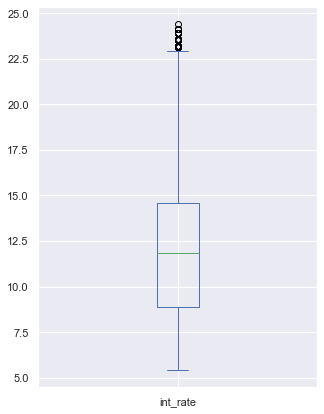

In [2712]:
sns.set(rc={'figure.figsize':(5,7)})
df["int_rate"].plot.box()

<AxesSubplot:>

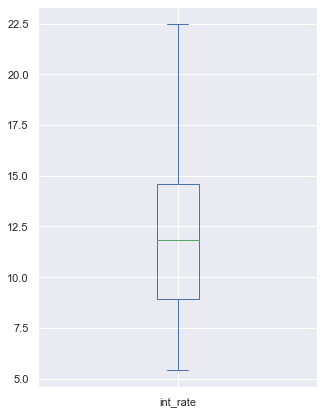

In [2713]:
sns.set(rc={'figure.figsize':(5,7)})
df[df["int_rate"] < 22.5]["int_rate"].plot.box()

In [2714]:
df = df[df["int_rate"] < 22.5]

<AxesSubplot:>

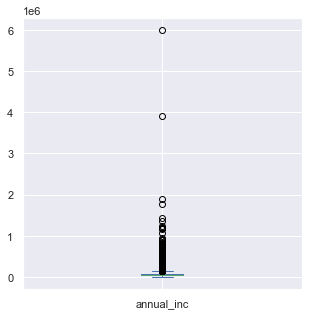

In [2715]:
sns.set(rc={'figure.figsize':(5,5)})
df["annual_inc"].plot.box()

In [2716]:
df = df[df["annual_inc"] < 125000]

<AxesSubplot:>

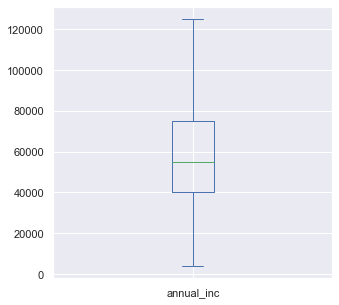

In [2717]:
df["annual_inc"].plot.box()

<AxesSubplot:>

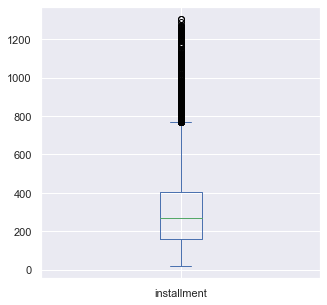

In [2718]:
df["installment"].plot.box()

In [2719]:
df = df[df["installment"] < 750]

<AxesSubplot:>

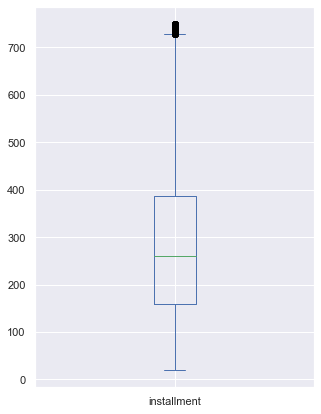

In [2720]:
sns.set(rc={'figure.figsize':(5,7)})
df["installment"].plot.box()

In [2721]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32570 entries, 0 to 37912
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   loan_amnt            32570 non-null  int64  
 1   term                 32570 non-null  object 
 2   int_rate             32570 non-null  float64
 3   installment          32570 non-null  float64
 4   grade                32570 non-null  object 
 5   sub_grade            32570 non-null  object 
 6   emp_length           32570 non-null  int64  
 7   home_ownership       32570 non-null  object 
 8   annual_inc           32570 non-null  float64
 9   verification_status  32570 non-null  object 
 10  loan_status          32570 non-null  int64  
 11  purpose              32570 non-null  object 
 12  addr_state           32570 non-null  object 
 13  dti                  32570 non-null  float64
 14  delinq_2yrs          32570 non-null  int64  
 15  inq_last_6mths       32570 non-null 

### Now let's plot a heatmap of correlation of all columns. It will give us a hint for which column to look into for further analysis

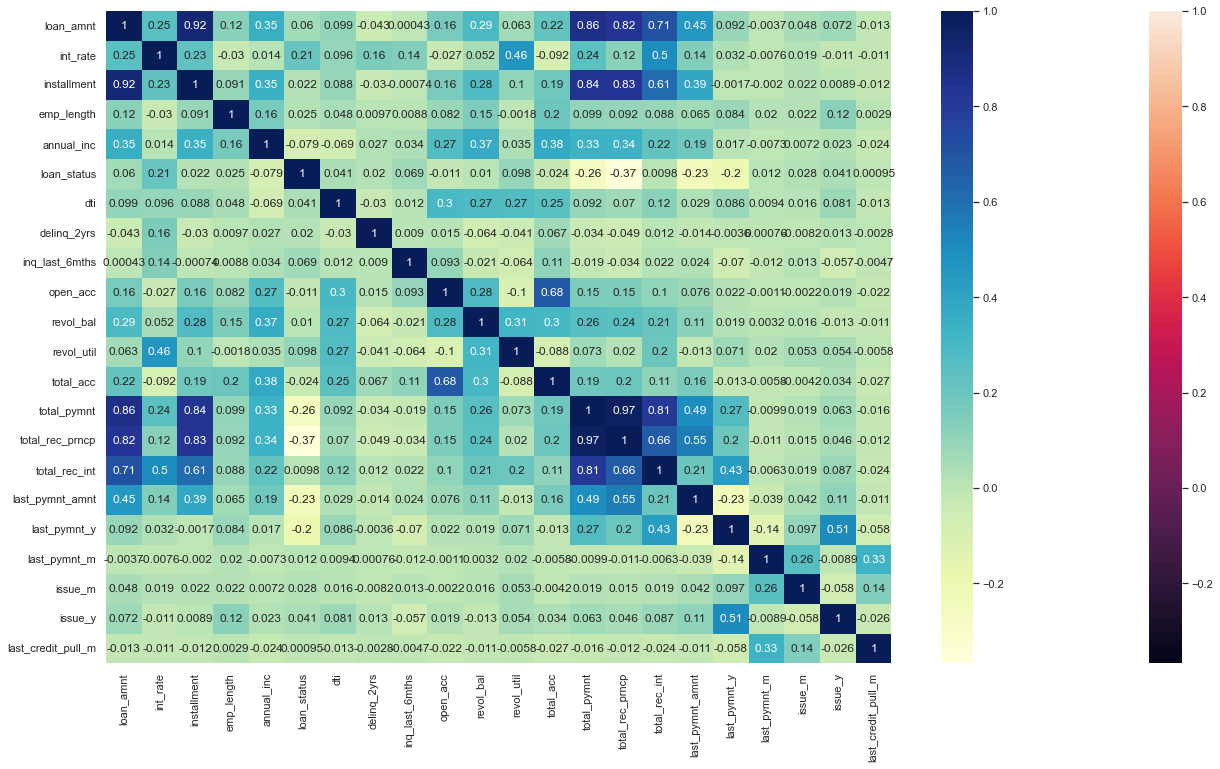

In [2722]:
sns.set(rc={'figure.figsize':(22,12)})

corrdf = df.corr()

sns.heatmap(corrdf)

sns.heatmap(corrdf,cmap="YlGnBu", annot=True)

plt.show()

### total_pymnt, total_rec_prncp, total_rec_int, loan_amnt, installment are highly correlated, let's keep only the first one


### int_rate is positively correlated with loan_status
### total_pymnt, total_rec_prncp, last_pymnt_y and last_pymnt_amnt are negatively correlated with loan_status. But as mentioned total_pymnt and total_rec_prncp are correlated, we will ignore total_rec_prncp

In [2723]:
df.drop(labels=["total_rec_prncp","total_rec_int"],axis=1,inplace=True)

In [2724]:
df.drop(labels=["loan_amnt"],axis=1,inplace=True)

In [2725]:
df.drop(labels=["installment"],axis=1,inplace=True)

In [2726]:
df["loan_status_catg"] = df["loan_status"].apply(lambda x: "Non Default" if x==0 else "Default")

#### We can see here, the ratio of defaulters to the total customers jumped suddenly from short term to long term

In [2727]:
sns.set(rc={'figure.figsize':(5,7)})

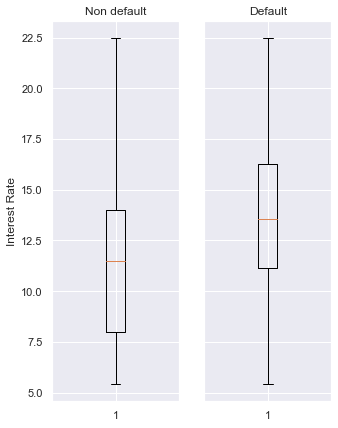

In [2728]:
fig, ax = plt.subplots(ncols=2, sharey=True)

ax[0].boxplot(df[df["loan_status_catg"] == "Non Default"]["int_rate"])
ax[1].boxplot(df[df["loan_status_catg"] == "Default"]["int_rate"])
ax[0].set_title("Non default")
ax[1].set_title("Default")
ax[0].set_ylabel('Interest Rate')


plt.show()

#### We can clearly see that customers with low interest rate tends to pay off their loan completely while the ones with higher interest rate tends to be defaulters. Median for non defaulters lie somewhere around 12% but the same for defaulters are somewhere near 13-13.5%. The interqaurtile range for non-defaulters is around 8 to 13.5 % whereas for defaulters it is 11 to 16%, which is quite some difference. And as we know, one percent change in interest rate, when compounded over years, could make a huge lot of difference

#### Let's analyse relation between loan_status and total_pymnt

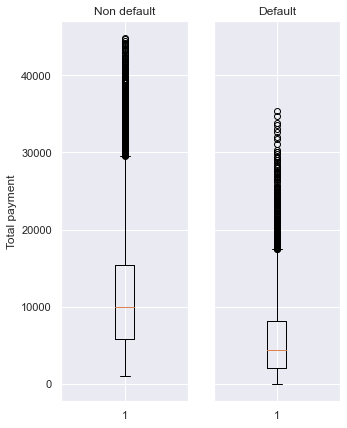

In [2729]:
fig, ax = plt.subplots(ncols=2, sharey=True)

ax[0].boxplot(df[df["loan_status_catg"] == "Non Default"]["total_pymnt"])
ax[1].boxplot(df[df["loan_status_catg"] == "Default"]["total_pymnt"])
ax[0].set_title("Non default")
ax[1].set_title("Default")
ax[0].set_ylabel('Total payment')

plt.show()

#### Customers with lower total_pyment tends to be defaulter. Here, the interquartile range and median is a clear give away.

#### Let's try the same exercise after removing the outliers

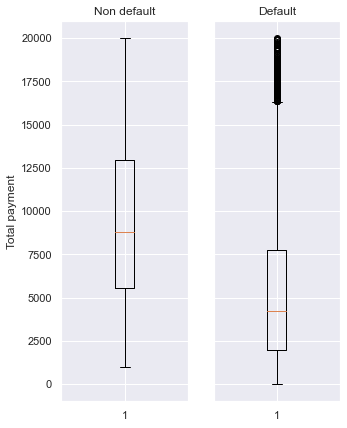

In [2730]:
fig, ax = plt.subplots(ncols=2, sharey=True)

ax[0].boxplot(df[(df["loan_status_catg"] == "Non Default") & (df["total_pymnt"] < 20000) ]["total_pymnt"])
ax[1].boxplot(df[(df["loan_status_catg"] == "Default") & (df["total_pymnt"] < 20000) ]["total_pymnt"])
ax[0].set_title("Non default")
ax[1].set_title("Default")
ax[0].set_ylabel('Total payment')

plt.show()

#### We can see the defaulters having total_pymnt over 17000 are outliers here, while the non- defaulters 75th percentile touches almost 20000. So non-defaulters tends to have much higher total_pymnt

#### Let's analyse relation between loan_status and last_pymnt_amnt

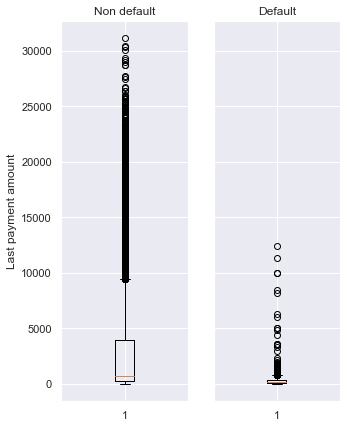

In [2731]:
fig, ax = plt.subplots(ncols=2, sharey=True)

ax[0].boxplot(df[df["loan_status_catg"] == "Non Default"]["last_pymnt_amnt"])
ax[1].boxplot(df[df["loan_status_catg"] == "Default"]["last_pymnt_amnt"])
ax[0].set_title("Non default")
ax[1].set_title("Default")
ax[0].set_ylabel('Last payment amount')

plt.show()

####  Even without removing the outliers, there is a starc contrast betweem two, defaulters have pretty low last_pymnt_amnt. A clear give away.

### We are still yet to analyse grades and subgrades with respect to loan_status. Let's do that

#### We will first convert grades and subgrades to integers and then do the analysis

In [2732]:
grades = df["grade"].unique()
print(grades)

['B' 'C' 'A' 'E' 'F' 'D' 'G']


In [2733]:
grades_int = np.arange(1,8)

In [2734]:
import warnings
warnings.filterwarnings("ignore")

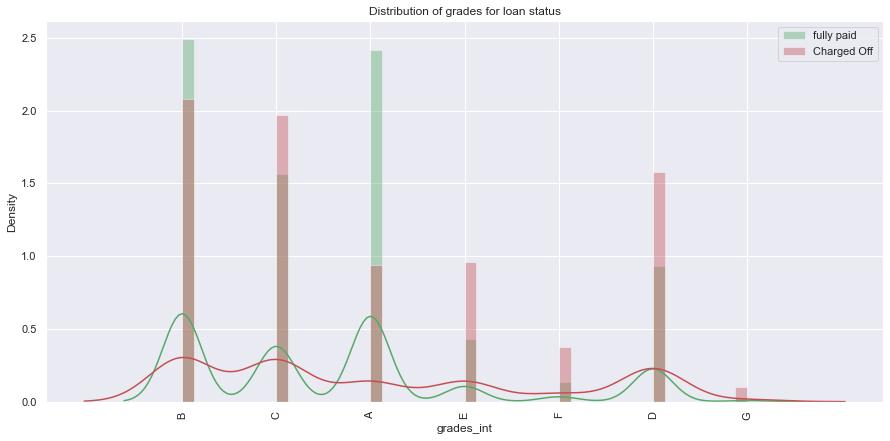

In [2735]:
# Here we are creating numerical codes for grades
# Create dictionary from grades -> numerical codes
# Create dictionary from numerical codes -> grades
grade_dict = {}
grade_dict_rev = {} # reverse dictionary for plotting ticks on x-axis
for x,y in zip(grades,grades_int):
    grade_dict[x] = y
    grade_dict_rev[y] = x
    
# Creating another column instead of changing same column. Because any of them could be used for further 
# analysis if needed
df["grades_int"] = df["grade"].apply(lambda x: grade_dict[x])
plt.figure(figsize=[15,7])
sns.distplot(df[df["loan_status"] == 0]["grades_int"], bins=48, color="g",label="fully paid")
sns.distplot(df[df["loan_status"] == 1]["grades_int"], bins=48, color="r",label="Charged Off")
plt.title("Distribution of grades for loan status", fontsize=12)
ticks = grades_int
labels = [grade_dict_rev[i] for i in ticks]
plt.xticks(ticks, labels)
plt.xticks(rotation=90)
plt.legend()
plt.show()

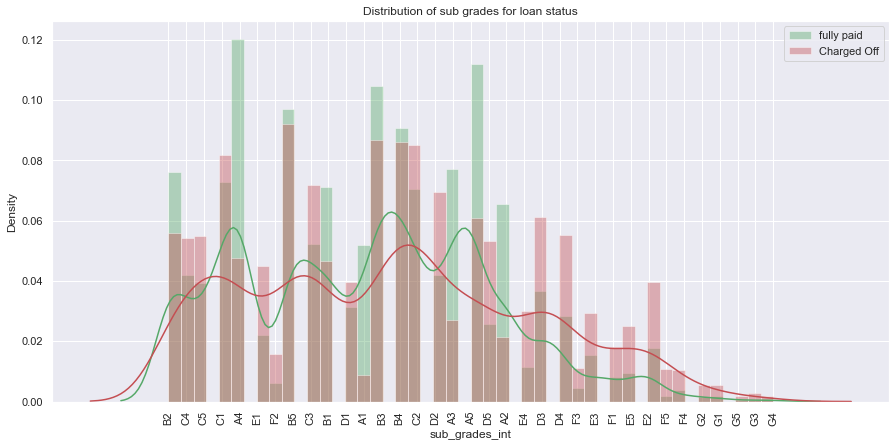

In [2736]:
# Same algorithm is followed that is used for grades column
# algorithm is described there in comments
sub_grades = df["sub_grade"].unique()
sub_grades_int = np.arange(1,36)
sub_grade_dict = {}
sub_grade_dict_rev = {}


for x,y in zip(sub_grades,sub_grades_int):
    sub_grade_dict[x] = y
    sub_grade_dict_rev[y] = x

sub_grades_int = np.arange(1,36)


for x,y in zip(sub_grades,sub_grades_int):
    sub_grade_dict[x] = y
    sub_grade_dict_rev[y] = x
    
df["sub_grades_int"] = df["sub_grade"].apply(lambda x: sub_grade_dict[x])  

plt.figure(figsize=[15,7])
sns.distplot(df[df["loan_status"] == 0]["sub_grades_int"], bins=48, color="g",label="fully paid")
sns.distplot(df[df["loan_status"] == 1]["sub_grades_int"], bins=48, color="r",label="Charged Off")
plt.title("Distribution of sub grades for loan status", fontsize=12)
ticks = sub_grades_int
labels = [sub_grade_dict_rev[i] for i in ticks]
plt.xticks(ticks, labels)
plt.xticks(rotation=90)
plt.legend()
plt.show()

####  Grade A and Grade B are likely to be non-defaulters
####  Sub grades tell the same story as well. Sub categories under A are safest while those under B seems safe as well.

### Let's analyse the relationship between given categorical variables and loan status

-  #### purpose
-  #### address state
-  #### term type 
-  #### home ownership
-  #### verification status

In [2737]:
df["helper"] = 1 # A helper column to help us measure aggregate for pivot tables

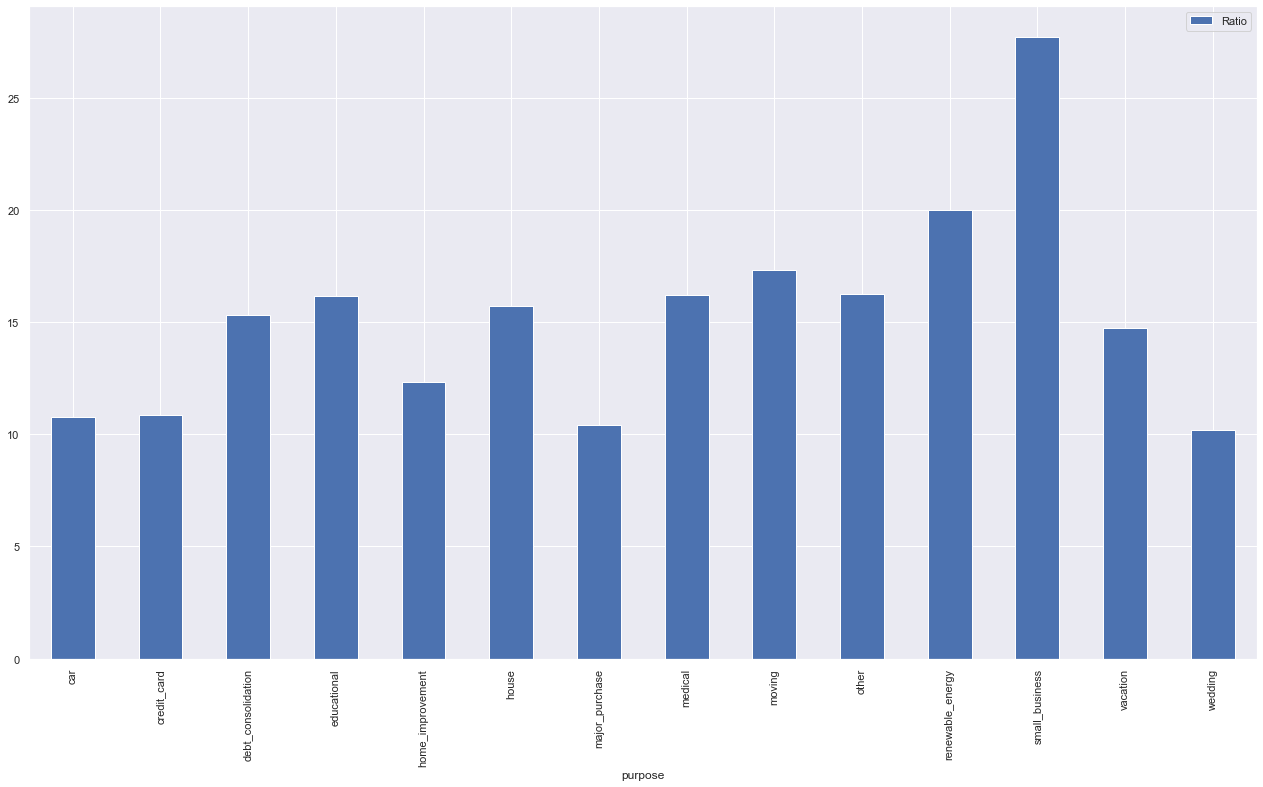

In [2738]:
sns.set(rc={'figure.figsize':(22,12)})
pvtPurpose = df.pivot_table(index="purpose",columns="loan_status_catg",values="helper", aggfunc = lambda x: x.sum())
pvtPurpose = pvtPurpose[(pvtPurpose["Default"].notnull()) & (pvtPurpose["Non Default"].notnull())]
def cal_ratio(x):
    return (x["Default"]/(x["Default"]+x["Non Default"]))*100
pvtPurpose["Ratio"] = pvtPurpose.apply(cal_ratio,axis=1)
pvtPurpose.plot(kind="bar",y="Ratio")

plt.show()

#### Loans taken for small businesses tend to get default. The reason could be small businesses could be risky and they couldn't make profit and hence defaulted

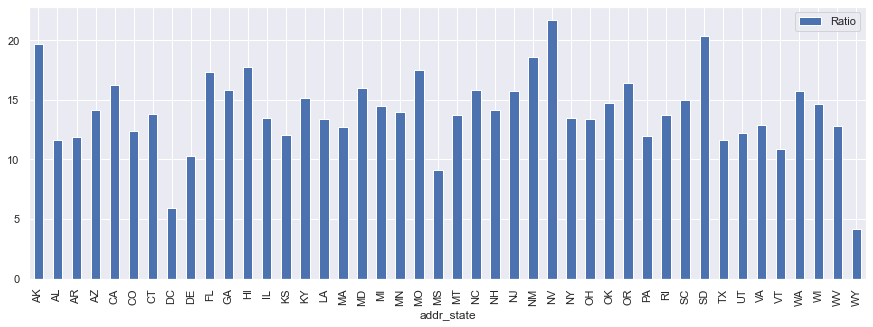

In [2739]:
sns.set(rc={'figure.figsize':(15,5)})
pvtState = df.pivot_table(index="addr_state",columns="loan_status_catg",values="helper", aggfunc = lambda x: x.sum())
pvtState = pvtState[(pvtState["Default"].notnull()) & (pvtState["Non Default"].notnull())]
def cal_ratio(x):
    return (x["Default"]/(x["Default"]+x["Non Default"]))*100
pvtState["Ratio"] = pvtState.apply(cal_ratio,axis=1)

pvtState.plot(kind="bar",y="Ratio")

plt.show()

#### Customers from 'NV', 'AK' and 'SD' state has a higher default ratio among others

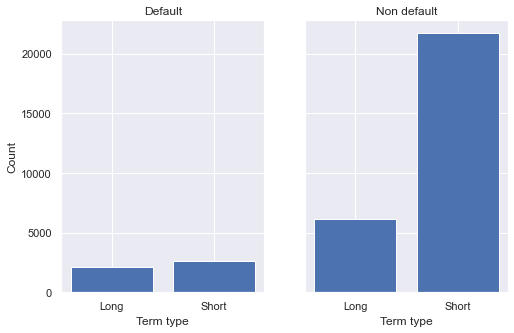

In [2740]:
sns.set(rc={'figure.figsize':(8,5)})
pvt = df.pivot_table(index="term", columns = "loan_status_catg", values="helper", aggfunc = lambda x: x.sum())
#def cal_ratio(x):
#    return (x["Default"]/(x["Default"]+x["Non Default"]))*100
pvt["Ratio"] = pvt.apply(cal_ratio,axis=1)
fig, ax = plt.subplots(ncols=2, sharey=True)
ax[0].bar(data = pvt, x= pvt.index, height = "Default")
ax[1].bar(data = pvt, x= pvt.index, height = "Non Default")
ax[0].set_title("Default")
ax[1].set_title("Non default")
ax[0].set_ylabel('Count')
ax[0].set_xlabel('Term type')
ax[1].set_xlabel('Term type')
plt.show()

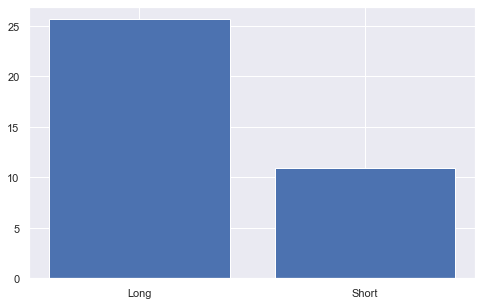

In [2741]:
plt.bar(data=pvt, x= pvt.index, height = "Ratio")
plt.show()

#### There is a certain strong correlation between loan term type and loan status. Loan with long term (60 months) has much higher default ratio as compared to short term loans. This is one of the strong driving factors for defaulted loans.

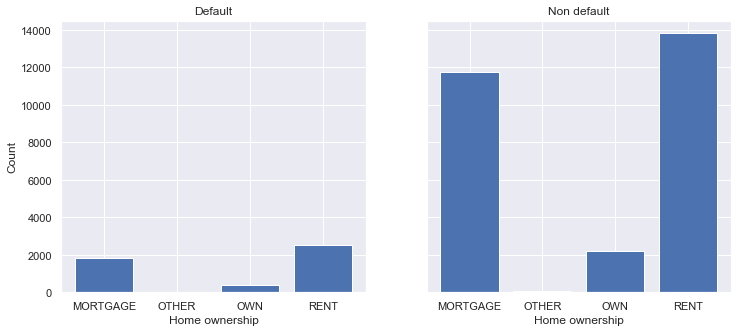

In [2742]:
sns.set(rc={'figure.figsize':(12,5)})
df["helper"] = 1
pvt = df.pivot_table(index="home_ownership", columns = "loan_status_catg", values="helper", aggfunc = lambda x: x.sum())
#def cal_ratio(x):
#    return (x["Default"]/(x["Default"]+x["Non Default"]))*100
pvt["Ratio"] = pvt.apply(cal_ratio,axis=1)
fig, ax = plt.subplots(ncols=2, sharey=True)
ax[0].bar(data = pvt, x= pvt.index, height = "Default")
ax[1].bar(data = pvt, x= pvt.index, height = "Non Default")
ax[0].set_title("Default")
ax[1].set_title("Non default")
ax[0].set_ylabel('Count')
ax[0].set_xlabel('Home ownership')
ax[1].set_xlabel('Home ownership')
plt.show()

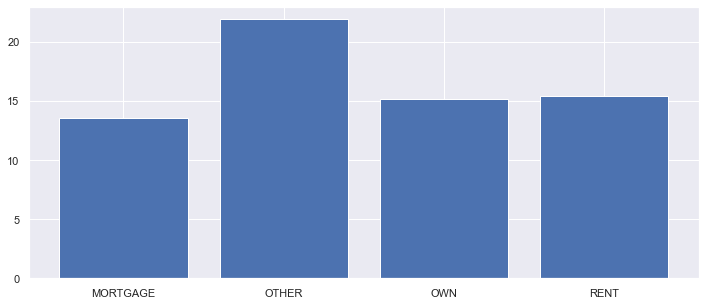

In [2743]:
plt.bar(data=pvt, x= pvt.index, height = "Ratio")
plt.show()

#### We can ignore 'Other' home ownership type since the records are not much. But other than that there is not much of a correlation between home ownership type and loan status

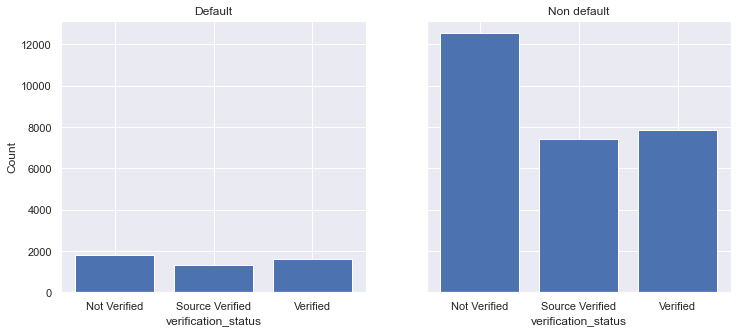

In [2744]:
#sns.set(rc={'figure.figsize':(12,5)})
pvt = df.pivot_table(index="verification_status", columns = "loan_status_catg", values="helper", aggfunc = lambda x: x.sum())
pvt["Ratio"] = pvt.apply(cal_ratio,axis=1)
fig, ax = plt.subplots(ncols=2, sharey=True)
ax[0].bar(data = pvt, x= pvt.index, height = "Default")
ax[1].bar(data = pvt, x= pvt.index, height = "Non Default")
ax[0].set_title("Default")
ax[1].set_title("Non default")
ax[0].set_ylabel('Count')
ax[0].set_xlabel('verification_status')
ax[1].set_xlabel('verification_status')
plt.show()

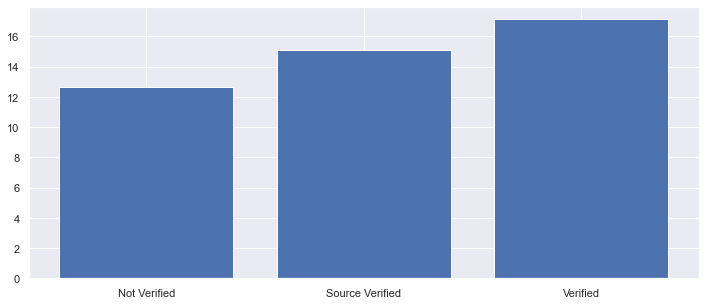

In [2745]:
plt.bar(data=pvt, x= pvt.index, height = "Ratio")
plt.show()

#### There is definite difference in the ratio, but it is not much. We can say there is a weak relationship between verification status and loan status

### Now let's analyse the months columns(derived)  from different date columns


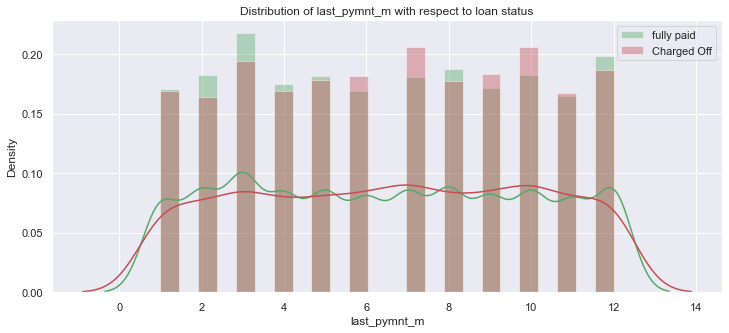

In [2746]:
sns.distplot(df[df["loan_status"] == 0]["last_pymnt_m"], bins=24, color="g",label="fully paid")
sns.distplot(df[df["loan_status"] == 1]["last_pymnt_m"], bins=24, color="r",label="Charged Off")
plt.title("Distribution of last_pymnt_m with respect to loan status", fontsize=12)
sns.set(rc={'figure.figsize':(12,10)})
plt.legend()
plt.show()

#### Not much correlation can be extracted from here

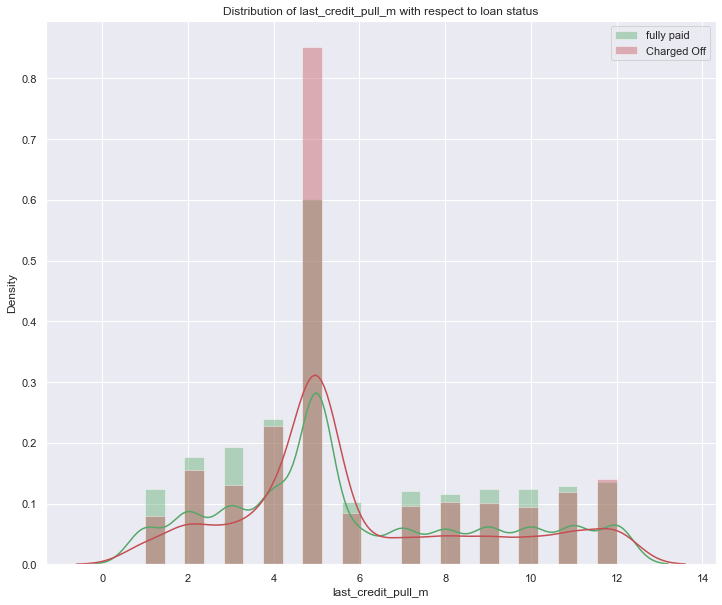

In [2747]:
sns.distplot(df[df["loan_status"] == 0]["last_credit_pull_m"], bins=24, color="g", label="fully paid")
sns.distplot(df[df["loan_status"] == 1]["last_credit_pull_m"], bins=24, color="r", label="Charged Off")
plt.title("Distribution of last_credit_pull_m with respect to loan status", fontsize=12)
sns.set(rc={'figure.figsize':(10,5)})
plt.legend()
plt.show()

#### Most of the defaulters have their last_credit_pull_m (month when LC pulled credit for loan) as May. It's an anamoly and certainly noticable

In [2748]:
sns.set(rc={'figure.figsize':(6,5)})

### We will play a little bit and try to find if there are any other factors driving the loan status

#### Let's try to find if loan issued year has some thing to do with defaults. Ofcourse even if it does and we don't know the reason behind it, it is difficult to use this factor for future analysis

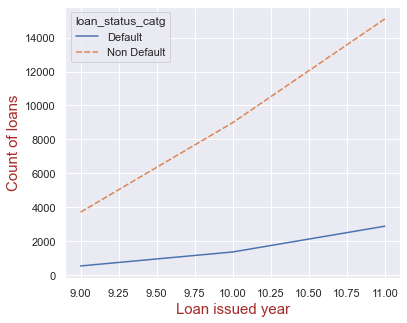

In [2749]:
df["helper"] = 1
pvt = df.pivot_table(index="issue_y",columns="loan_status_catg",values ="helper",aggfunc = lambda x:x.sum())
sns.lineplot(data=pvt)
plt.ylabel("Count of loans", fontdict={'fontsize': 15, 'fontweight' : 5, 'color' : 'Brown'})
plt.xlabel("Loan issued year", fontdict={'fontsize': 15, 'fontweight' : 5, 'color' : 'Brown'})
plt.show()

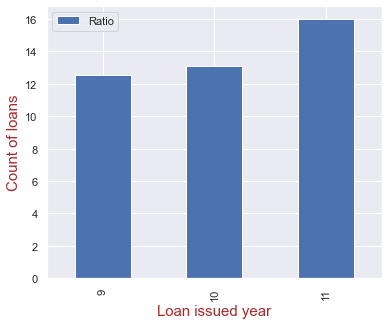

In [2750]:
pvt["Ratio"] = pvt.apply(cal_ratio,axis=1)

pvt.plot(kind="bar",y="Ratio")
plt.ylabel("Count of loans",fontdict={'fontsize': 15, 'fontweight' : 5, 'color' : 'Brown'})
plt.xlabel("Loan issued year", fontdict={'fontsize': 15, 'fontweight' : 5, 'color' : 'Brown'})
plt.show()

#### There is something about loan issued in year 2011. It has the most percentage of loan defaults as compared to the previous years. Point to be considered

#### Now we will try to decipher of total credit revolving balance in conjuction with interest rate has to do with defaulted loans. 

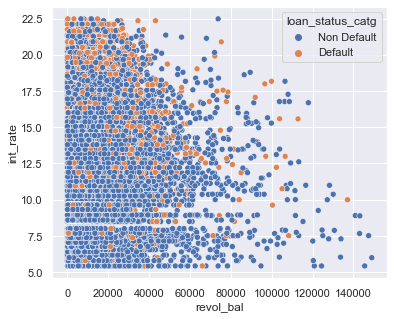

In [2751]:
g = sns.scatterplot(data = df, x= "revol_bal",y="int_rate", hue="loan_status_catg")
new_labels = ['Fully Paid', 'Default']
#plt.legend(labels=new_labels)
plt.show()

#### We can clearly see that irrespective of credit revolving balance, higher interest rate is causing more defaults. Which we have already noticed through the heatmap. So total credit revolving balance doesn't play much of a rale with respect to interest to determine defaults.
#### We will do the same exercise with annual income instead of revolving balance.

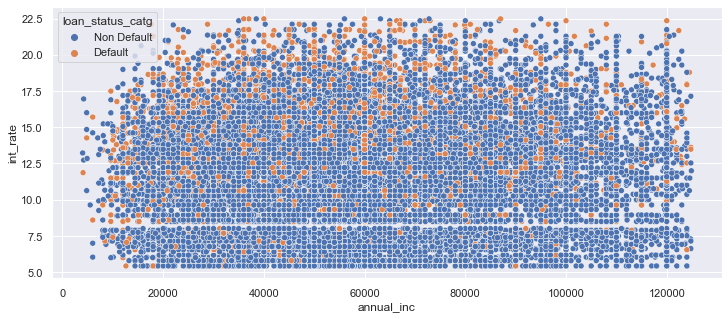

In [2752]:
sns.set(rc={'figure.figsize':(12,5)})
sns.scatterplot(data = df, x= "annual_inc",y="int_rate", hue="loan_status_catg")
plt.show()

#### And as we see, nothing can be concluded from annual income point of view.

#### It is clearly visible that the loans taken in year 2011 have defaulted more in comparison to previous years. This is history, so until unless we don't know the actual reason behind it we cannot predict how it is going to be used for future prediction

## Summary

-  #### Loan with high interest tend to be defaulted
-  #### Loan term is correlated with loan status as well. Customers with long term loan tend to be defaulters as compared to customers with short term loan
-  #### Customers who have paid large amount of total payment of loan (total_pymnt) tends to be non defaulter and vice versa is also true
-  #### Customers with lesser last payment paid(last_pymnt_amnt) towards their loan tend to be defaulters and vice versa
-  #### Loans with LC assigned loan grade A and B tend to be non default
-  #### Loan with LC assigned loan sub grades under A and B are likely to be non default (same conclusion as above point)
-  #### Loans with last_credit_pull_m(month when LC pulled credit for loan) as May, tend to get defaulted
-  #### Customers who take loan for small businesses tend to be defaulter. The reason could be small businesses are risky and they couldn't make profit and hence defaulted
-  #### Loans taken from NV, AK and SD state has higher default ratio